# Datasets

In [ ]:
from sklearn.datasets import load_iris, fetch_california_housing, load_diabetes

# iris = load_iris(return_X_y=True, as_frame=True)[0]
# housing = fetch_california_housing(return_X_y=True, as_frame=True)[0]
housing = pd.read_csv("housing.csv")
# diabetes = load_diabetes(return_X_y=True, as_frame=True)[0]

In [2]:
# iris

In [3]:
housing

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [4]:
# diabetes

# Super Class and Utils

## Feature

In [5]:
from math import log, e
import numpy as np
import pandas as pd

class feature():

    @staticmethod
    def get_count(data):
        """
        equivalent to return len(data), data.value_counts()
        """
        n_labels = len(data)     
        value, counts = np.unique(data, return_counts=True)
        return n_labels, (value, counts)
    
    # def entropy_scipy(probs):
    #      # `pd.Series` with scipy
    #     p_data = data.value_counts()           # counts occurrence of each value 
    #     return  scipy.stats.entropy(p_data)    # get entropy from counts
    #     # return  scipy.stats.entropy(probs)    # get entropy from prob
     
    @staticmethod
    def entropy_numpy(n_labels, freq, base=2):
    # def entropy_numpy(probs, base=2):
        """ Computes entropy of label distribution with numpy. """

        if n_labels <= 1:
            return 0 
        probs = freq / n_labels
        probs = probs[probs>0]
        
        n_classes = np.count_nonzero(probs)        
        if n_classes <= 1:
            return 0
        
        # Compute entropy
        # base = e if base is None else base
        ent = 0.
        for prob in probs:
            ent -= prob * log(prob, base)
        return ent

    @staticmethod
    def get_data_type(series: pd.Series) -> str:
        # Check if the series is empty
        if series.empty:
            return "Empty"
        
        # Check if the series is of datetime type
        if pd.api.types.is_datetime64_any_dtype(series):
            return "Datetime"
        
        # Check if the series is boolean
        if pd.api.types.is_bool_dtype(series):
            return "Binary"
        
        # Check if the series is numeric (int or float)
        if pd.api.types.is_numeric_dtype(series):
            # If there are only 2 unique values, treat as binary
            if series.nunique() == 2:
                return "Binary"
            else:
                return "Continuous"
        
        # If the series is an object (e.g., strings or mixed types)
        if pd.api.types.is_object_dtype(series):
            unique_values = series.nunique()
            total_values = len(series)
            
            # Consider the series categorical if unique values are relatively small
            if unique_values / total_values < 0.05:
                return "Categorical"
            else:
                return "Text"
        
        return "Unknown"

## Viz

In [6]:
from abc import ABC, abstractmethod, ABCMeta
import matplotlib.pyplot as plt


class Viz(ABC):
    """
    Abstract base class for creating different types of visualizations.
    
    Attributes:
    -----------
    data_type : tuple
        A tuple representing the data type of the columns in the DataFrame or Series.
    column_name : tuple
        A tuple containing the names of the columns.
    feature : Any
        The computed feature for the visualization (defined in child classes).
    """
    
    def __init__(self, column_data: pd.DataFrame | pd.Series, feature_w_column_data=False):
        
        if isinstance(column_data, pd.Series):
            # Convert Series to DataFrame
            column_data = column_data.to_frame()
        elif not isinstance(column_data, pd.DataFrame):
            # Raise an error if the input is not a DataFrame or Series
            raise TypeError("Expected column_data to be a pandas DataFrame or Series")
        
        self.data_type   = tuple(feature.get_data_type(data) for _, data in column_data.items())
        self.column_name = tuple(column_name for column_name in column_data)
        if feature_w_column_data:
            self.feature     = self._compute_feature(column_data)
        else:
            self.feature     = self._compute_feature()
            

        
    @abstractmethod
    def get_params(self):
        """
        Abstract method to return the parameters of the visualization.
        This must be implemented by subclasses.
        
        Returns:
        --------
        dict
            A dictionary of parameters related to the visualization.
        """

    @abstractmethod
    def _compute_feature(self, **kwargs):
        """
        Abstract method to compute a feature of the data.
        This must be implemented by subclasses.
        
        Returns:
        --------
        Any
            The computed feature based on the data.
        """
        print(self, kwargs)
        pass

    @abstractmethod
    def plt(self, **kwargs):
        """
        Abstract method to plot the visualization.
        This must be implemented by subclasses.

        Parameters:
        -----------
        **kwargs : optional
            Additional keyword arguments for customizing the plot.
        """
        pass

## Viz Selector

In [7]:
from itertools import combinations

class VizSelector():

    def __init__(self, vizs: Viz):
        """Initialize with a list of visualization objects"""
        self.vizs = vizs

    @classmethod
    def hist(cls, df: pd.DataFrame):
        """Create VizSelector for 1D visualizations (e.g., Histograms)"""
        vizs = [Histogram(data) for _, data in df.items()]
        return cls(vizs)

    @classmethod
    def scatter(cls, df: pd.DataFrame):
        """Create VizSelector for 2D visualizations (e.g., Scatter plots)"""
        column_pairs = combinations(df.columns, 2)
        vizs = [Scatter(df[[x, y]]) for x, y in column_pairs]
        return cls(vizs)

    @classmethod
    def create(cls, df: pd.DataFrame, viz_type: str):
        """Factory method to choose correct visualization type"""
        model_map = {
            "hist": cls.hist,
            "scatter": cls.scatter
        }
        if viz_type not in model_map:
            raise ValueError(f"Unknown visualization type: {viz_type}")
        return model_map[viz_type](df)
    
    def rank(self):
        vizs_sorted = sorted(self.vizs, key=lambda x: x.get_params()["feature"], reverse=True)
        return vizs_sorted
    
    def rank5(self):
        return self.rank()[:5]
    
    def plt(self):
        _, axs = plt.subplots(1, 5, figsize=(20, 4))
        for idx, obj in enumerate(self.rank5()):
            obj.plt(axs=axs[idx])

# 1D

## Histogram

In [8]:
class Histogram(Viz):

    def __init__(self, column_data: pd.Series):
        #
        # self.data_len, self.data_freq = feature.get_count(column_data)
        self.data_len = len(column_data)
        self.frequency, self.bins = np.histogram(column_data, bins=10, range=[(column_data.min() if column_data.min() < 0 else 0 ), column_data.max()], density=False)
        # self.params = self.calculate_hist_params(column_data)
        super().__init__(column_data)

    # TODO replace frequency, bin to params in init
    # def calculate_hist_params(series: pd.Series) -> dict:
    #     frequency, bins = np.histogram(series, bins=10, range=[(series.min() if series.min() < 0 else 0 ), series.max()], density=False)
    #     return {"frequency": frequency, "bins": bins}
        
    def _compute_feature(self):
        """Calculates entropy"""
        # TODO timeit 
        # scipy_entr = feature.entropy_scipy(self.data_len, self.frequency)
        numpy_entr = feature.entropy_numpy(self.data_len, self.frequency)

        # print(scipy_entr, numpy_entr)
        return numpy_entr

    def get_params(self):
        # return self.feature, self.data_len, self.data_freq
        return {"feature": self.feature, "params": (self.frequency, self.bins)}

    def plt(self, **kwargs):
        if 'axs' in kwargs :
            ax = kwargs["axs"]
            ax.bar(self.bins[:-1], self.frequency, width=np.diff(self.bins), edgecolor="black", align="edge")
            if 'title_idx' in kwargs :
                ax.set_title(f"{self.column_name[0]} ({kwargs['title_idx']})" )
        else:
            ## Printar linha y com a distribuição
            _, ax = plt.subplots()
            ax.bar(self.bins[:-1], self.frequency, width=np.diff(self.bins), edgecolor="black", align="edge")
            # ax.title(f"{self.column_name[0]}")
            if 'title_idx' in kwargs :
                ax.set_title(f"{self.column_name[0]} ({kwargs['title_idx']})" )
            # plt.stairs(self.frequency, self.bins, fill=True)

In [9]:
# hist_obj = Histogram(housing["HouseAge"])

In [10]:
# hist_obj.plt()

In [11]:
# hist_obj.get_params()

In [12]:
# hist_obj.data_type

In [13]:
from abc import abstractmethod, ABC, ABCMeta
import pandas as pd


class Viz(ABC):
    """
    Abstract base class for creating different types of visualizations.
    
    Attributes:
    -----------
    data_type : tuple
        A tuple representing the data type of the columns in the DataFrame or Series.
    column_name : tuple
        A tuple containing the names of the columns.
    feature : Any
        The computed feature for the visualization (defined in child classes).
    """
    
    def __init__(self, column_data: pd.DataFrame | pd.Series, feature_w_column_data=False):
        
        if isinstance(column_data, pd.Series):
            # Convert Series to DataFrame
            column_data = column_data.to_frame()
        elif not isinstance(column_data, pd.DataFrame):
            # Raise an error if the input is not a DataFrame or Series
            raise TypeError("Expected column_data to be a pandas DataFrame or Series")
        
        self.data_type   = tuple(feature.get_data_type(data) for _, data in column_data.items())
        self.column_name = tuple(column_name for column_name in column_data)
        if feature_w_column_data:
            self.feature     = self._compute_feature(column_data)
        else:
            self.feature     = self._compute_feature()

        
    @abstractmethod
    def get_params(self):
        """
        Abstract method to return the parameters of the visualization.
        This must be implemented by subclasses.
        
        Returns:
        --------
        dict
            A dictionary of parameters related to the visualization.
        """

    @abstractmethod
    def _compute_feature(self, kwargs):
        """
        Abstract method to compute a feature of the data.
        This must be implemented by subclasses.
        
        Returns:
        --------
        Any
            The computed feature based on the data.
        """
        pass

    @abstractmethod
    def plt(self, **kwargs):
        """
        Abstract method to plot the visualization.
        This must be implemented by subclasses.

        Parameters:
        -----------
        **kwargs : optional
            Additional keyword arguments for customizing the plot.
        """
        pass

## Box plot

In [14]:
from scipy.stats import skew, skewtest


class BoxPlot(Viz):

    def __init__(self, column_data):
        self.data_len     = len(column_data)
        self.params       = BoxPlot.calculate_boxplot_params(column_data)
        super().__init__(column_data, feature_w_column_data=True)
    
    def calculate_boxplot_params(series: pd.Series) -> dict:
        """
        Calculate the boxplot parameters (min, Q1, median, Q3, max, and outliers) from a pandas Series.
        """
        q1 = series.quantile(0.25)
        median = series.median()
        q3 = series.quantile(0.75)
        iqr = q3 - q1  # Interquartile range
        whisker_low = q1 - 1.5 * iqr
        whisker_high = q3 + 1.5 * iqr
        
        # Calculate min and max within the whiskers
        # min_val = series[series >= whisker_low].min()
        # max_val = series[series <= whisker_high].max()
        
        # Identify outliers (fliers)
        outliers = series[(series < whisker_low) | (series > whisker_high)].values
    
        return {
            'whislo': whisker_low,   # Bottom whisker position
            'q1': q1,        # First quartile (25th percentile)
            'med': median,   # Median (50th percentile)
            'q3': q3,        # Third quartile (75th percentile)
            'whishi': whisker_high,   # Top whisker position
            'fliers': outliers,  # Outliers
            }
        
    # def skewness_test(serie :pd.Series, alpha=0.05):
    #     # Perform the Kolmogorov-Smirnov test
    #     _, p_value = skewtest(serie)
        
    #     # Compare p-value with the significance level
    #     similar = p_value > alpha

    @classmethod
    def skewness_test(cls, series: pd.Series, alpha=0.05):
        """
        Test the skewness of a Pandas Series and determine if it is statistically significant.
        
        Parameters:
            series (pd.Series): The data series to test.
            alpha (float): Significance level for the test. Default is 0.05.
            
        Returns:
            float: The skewness of the series.
            bool: True if skewness is statistically significant, False otherwise.
            float: The p-value of the skewness test.
        """
        # Calculate skewness
        skewness_value = skew(series)[0]

        # Perform skewness test
        # statistic, p_value = skewtest(series)
        
        # Determine if skewness is statistically significant
        # is_significant = p_value < alpha
        return abs(skewness_value)#, statistic, p_value, is_significant

    def outlier_percentage(self):
        n_outliers = len(self.params["fliers"])
        return  (n_outliers/self.data_len)*100
        
    def _compute_feature(self, series):
        """Calculates skewness"""
        skewness_value     = BoxPlot.skewness_test(series)
        outlier_percentage = self.outlier_percentage()
        return (skewness_value+1), (outlier_percentage+0.5)

    def get_params(self):
        return {"feature": self.feature, **self.params}

    def plt(self, **kwargs):
        if "axs" in kwargs :
            ax = kwargs["axs"]
            ax.bxp([self.params], showfliers=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
            ax.set_xticklabels([*self.column_name]) # Rotaciona o rótulo do eixo x
            if "title_idx" in kwargs:
                ax.set_title(f"({kwargs['title_idx']})")
        else:
            # plt.boxplot(column_data, patch_artist=True)  # fill with random  color
            _, ax = plt.subplots()
            ax.bxp([self.params], showfliers=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
            ax.set_xticklabels([*self.column_name]) # Rotaciona o rótulo do eixo x 
            # ax.set_title(kwargs["title_idx"])

In [15]:
box_obj = BoxPlot(housing["AveRooms"])

In [16]:
box_obj.get_params()

{'feature': (np.float64(21.69636472075092), 2.97577519379845),
 'whislo': np.float64(2.023219161170969),
 'q1': np.float64(4.440716235896959),
 'med': np.float64(5.229128787878788),
 'q3': np.float64(6.052380952380952),
 'whishi': np.float64(8.469878027106942),
 'fliers': array([  1.71428571,   8.97286822,   8.92835821,   9.21022727,
          9.1227154 ,   9.        ,   8.51824818,   8.97368421,
         10.51530612,  29.85294118,   8.62530414,  10.16859122,
         31.77777778,  16.84753363,  28.75728155,  13.47303922,
         11.49086162,   9.79302832,  28.11290323,  33.98969072,
         47.51515152,   8.52729384,   9.26359833,   8.48104575,
          8.60629921,   8.94675926,   8.74031008,  10.51162791,
         22.22222222,   9.01611279,   9.36170213,   8.54092527,
          9.10421639,   8.80253165,   8.85306122,  23.88888889,
          9.77578475,  38.84090909,  13.10416667,  10.63945578,
          8.88603989,  20.90078329,  11.18326693,   9.30838323,
         11.67987805,   

In [17]:
# BoxPlot(housing["Longitude"]).plt()

In [18]:
# a = [(c,BoxPlot(housing[c]).get_params()["feature"]) for c in housing.columns]
# b = [(*c, c[1][0]*c[1][1]) for c in a]
# sorted(b, key=lambda x: x[2], reverse=True)

In [19]:
def skewness_test(series: pd.Series, alpha=0.05):
        """
        Test the skewness of a Pandas Series and determine if it is statistically significant.
        
        Parameters:
            series (pd.Series): The data series to test.
            alpha (float): Significance level for the test. Default is 0.05.
            
        Returns:
            float: The skewness of the series.
            bool: True if skewness is statistically significant, False otherwise.
            float: The p-value of the skewness test.
        """
        # Calculate skewness
        skewness_value = skew(series)
        
        # Perform skewness test
        statistic, p_value = skewtest(series)
        
        # Determine if skewness is statistically significant
        is_significant = p_value < alpha
        
        return abs(skewness_value), statistic, p_value, is_significant
    
from scipy.stats import skewtest

for c in housing.columns:
    print(f"{c}, {skewness_test(housing[c])}")#, {skewness_test(housing[c])[3] < 0.05}")
    
    
housing.columns

MedInc, (np.float64(1.64653702990008), np.float64(69.52770757945211), np.float64(0.0), np.True_)
HouseAge, (np.float64(0.06032625301661101), np.float64(3.5363016726494374), np.float64(0.0004057710457661161), np.True_)
AveRooms, (np.float64(20.69636472075092), np.float64(188.16680164298248), np.float64(0.0), np.True_)
AveBedrms, (np.float64(31.314680259248195), np.float64(208.00642899994543), np.float64(0.0), np.True_)
Population, (np.float64(4.93549950885852), np.float64(119.76204417761278), np.float64(0.0), np.True_)
AveOccup, (np.float64(97.63246492211677), np.float64(262.5039868494181), np.float64(0.0), np.True_)
Latitude, (np.float64(0.46591914016270397), np.float64(26.03726026974292), np.float64(1.8755989868608524e-149), np.True_)
Longitude, (np.float64(0.29777956498586855), np.float64(-17.10612530849365), np.float64(1.3359636432618334e-65), np.True_)


Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [ ]:
def plt_all(self):
    n_vizs =  len(self.vizs)
    _, axs = plt.subplots(1, n_vizs, figsize=(5*n_vizs, 4))
    for idx, obj in enumerate(self.vizs):
        obj.plt(axs=axs[idx])    
        
plt_all(VizSelector.create(housing, "box"))


[('AveOccup', (np.float64(98.63246492211677), 3.944767441860465), np.float64(389.0821363352106)), ('AveBedrms', (np.float64(32.31468025924819), 7.399224806201551), np.float64(239.1035837787008)), ('AveRooms', (np.float64(21.69636472075092), 2.97577519379845), np.float64(64.56350393161442)), ('Population', (np.float64(5.93549950885852), 6.294573643410852), np.float64(37.361438768938896)), ('MedInc', (np.float64(2.64653702990008), 3.799418604651163), np.float64(10.055302029300595)), ('Latitude', (np.float64(1.465919140162704), 0.5), np.float64(0.732959570081352)), ('Longitude', (np.float64(1.2977795649858686), 0.5), np.float64(0.6488897824929343)), ('HouseAge', (np.float64(1.060326253016611), 0.5), np.float64(0.5301631265083055))]


[None, None, None, None, None, None, None, None]

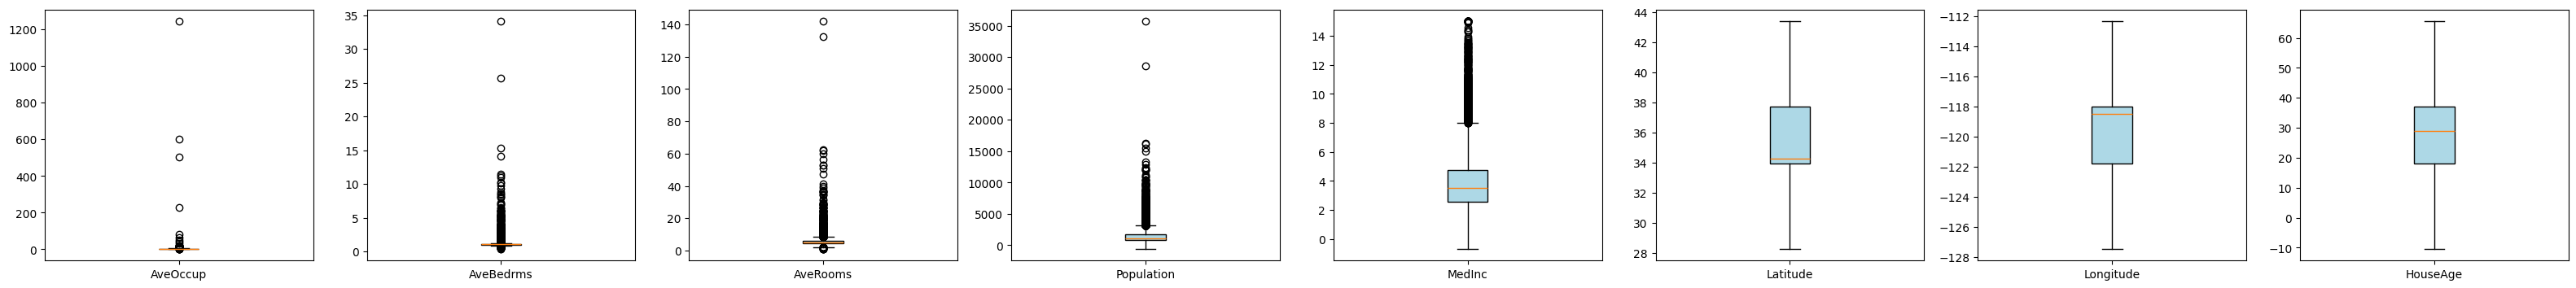

In [ ]:
a = [(c,BoxPlot(housing[c]).get_params()["feature"]) for c in housing.columns]
b = [(*c, c[1][0]*c[1][1]) for c in a]
b = sorted(b, key=lambda x: x[2], reverse=True)
print(b)
_, ax = plt.subplots(1, 8, figsize=(5*8, 4))
[BoxPlot(housing[obj[0]]).plt(axs=ax[idx]) for idx, obj in enumerate(b)]

In [ ]:
import sys, os
sys.path.append(os.path.abspath('..')) # add path
from utils.VizSelector import VizSelector

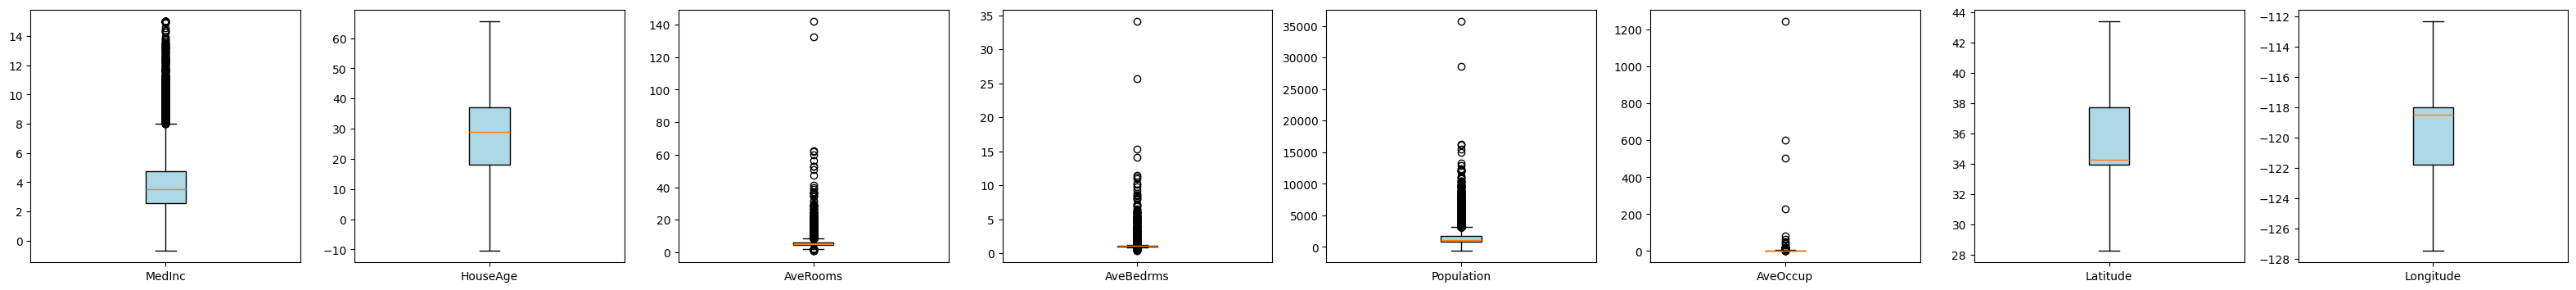

In [ ]:
def plt_all(self):
    n_vizs =  len(self.vizs)
    _, axs = plt.subplots(1, n_vizs, figsize=(5*n_vizs, 4))
    for idx, obj in enumerate(self.vizs):
        obj.plt(axs=axs[idx])    
        
plt_all(VizSelector.create(housing, "box"))

In [ ]:
# box_obj.get_params()

In [ ]:
# box_obj.data_type

In [ ]:
# plt.boxplot(housing["HouseAge"], patch_artist=True, boxprops=dict(facecolor='lightblue')) 
# plt.xticks([1], ["HouseAge"], rotation=45) # Rotaciona o rótulo do eixo x
# plt.show()

# 2D

## ScatterPlot

In [ ]:
from scipy.stats import pearsonr   

class Scatter(Viz):

    def __init__(self, data: pd.DataFrame):
        self.x, self.y = data.T.values
        super().__init__(data)

    def _compute_feature(self):
        """Calculates corr"""
        # TODO timeit 
        corr = pearsonr(self.x, self.y)
        return corr

    def get_params(self):
        return {"feature": self.feature, "params": None}

    def plt(self, **kwargs):
        if 'axs' in kwargs :
            kwargs["axs"].scatter(self.x, self.y)
            kwargs["axs"].set_title(f"{self.column_name[0]} x {self.column_name[1]}")
        else:
            ## Printar linha y com a distribuição
            plt.scatter(self.x, self.y)
            plt.title(f"{self.column_name[0]} x {self.column_name[1]}")
                

In [ ]:
obj = Scatter(housing[["HouseAge","MedInc"]])
obj.get_params()

{'feature': PearsonRResult(statistic=np.float64(-0.11903398993785667), pvalue=np.float64(5.185138325252411e-66)),
 'params': None}

In [ ]:
housing[["HouseAge","MedInc"]]

,HouseAge,MedInc
0,41.0,8.3252
1,21.0,8.3014
2,52.0,7.2574
3,52.0,5.6431
4,52.0,3.8462
...,...,...
20635,25.0,1.5603
20636,18.0,2.5568
20637,17.0,1.7000
20638,18.0,1.8672


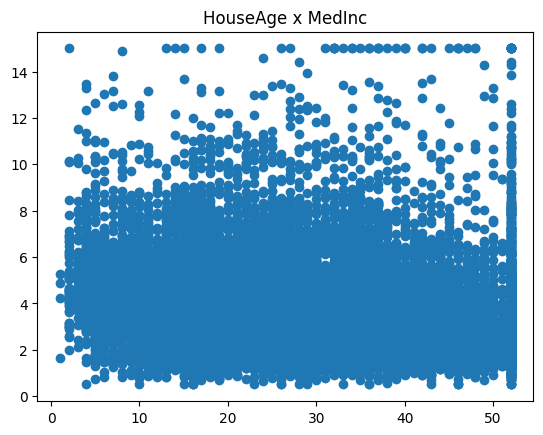

In [ ]:
obj.plt()

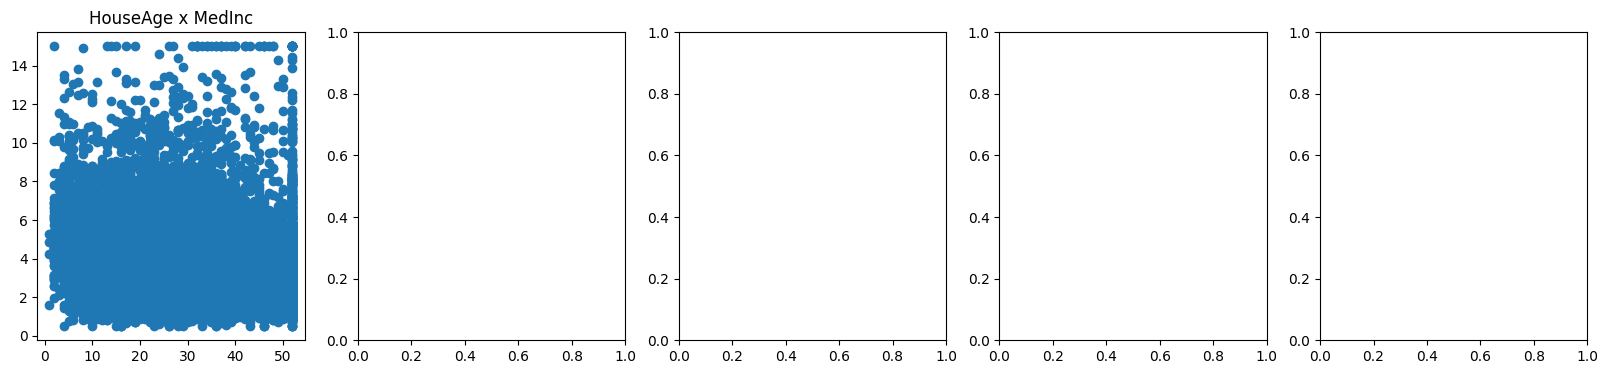

In [ ]:
_, axs = plt.subplots(1, 5, figsize=(20, 4))
# axs[0].scatter(obj.x, obj.y)
obj.plt(axs=axs[0])

<Axes: xlabel='MedInc'>

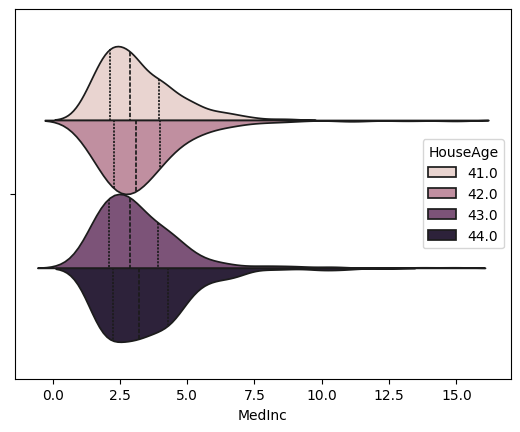

In [ ]:
import seaborn as sns 

sns.violinplot(data=housing[(housing["HouseAge"] == 41.0) | (housing["HouseAge"] == 42) | (housing["HouseAge"] == 43) | (housing["HouseAge"] == 44)][["HouseAge","MedInc"]], x="MedInc", hue="HouseAge", split=True, inner="quart")

In [ ]:
housing[(housing["HouseAge"] == 41.0)][["HouseAge","MedInc"]]

,HouseAge,MedInc
0,41.0,8.3252
25,41.0,2.4038
52,41.0,1.1108
120,41.0,5.9560
166,41.0,1.6121
...,...,...
20215,41.0,3.0799
20218,41.0,4.4038
20219,41.0,4.8977
20224,41.0,2.6333


[None, None, None, None, None, None, None, None]

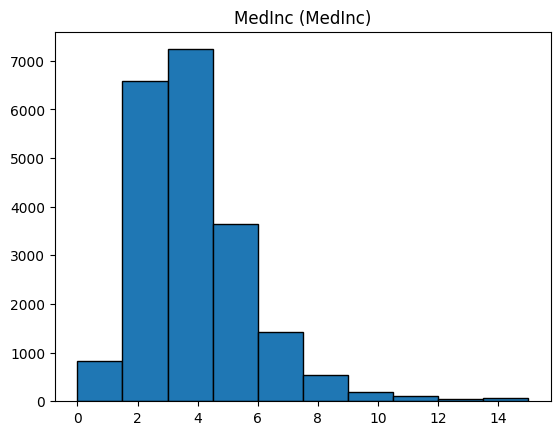

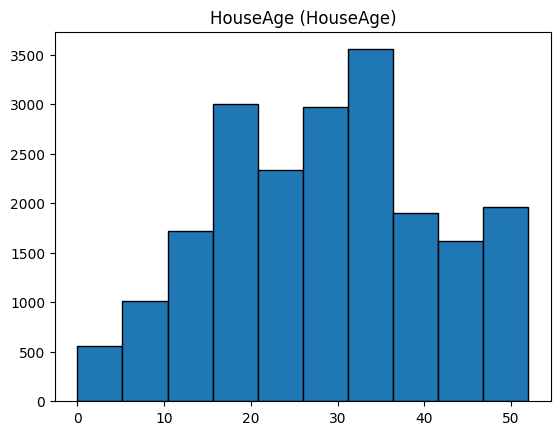

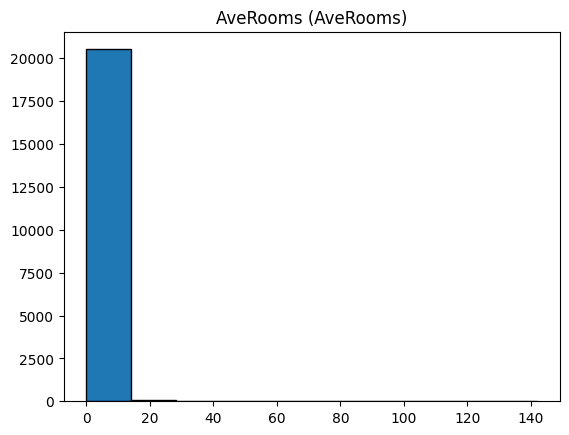

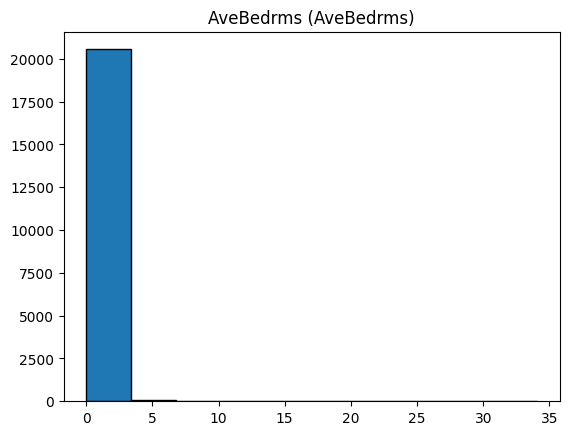

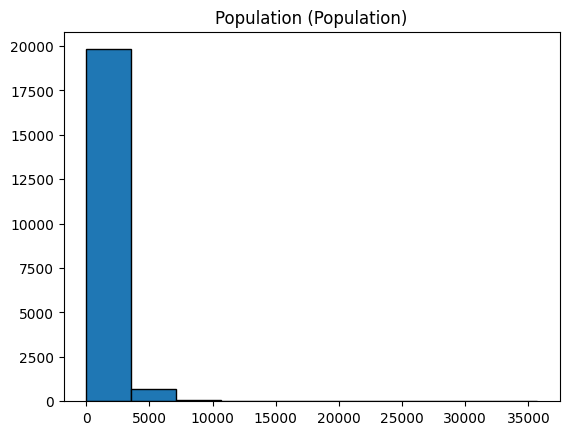

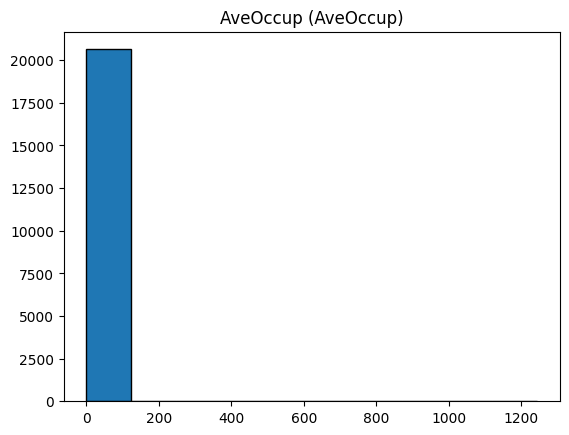

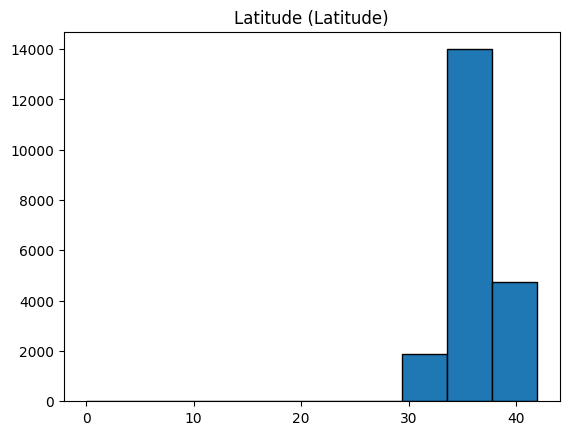

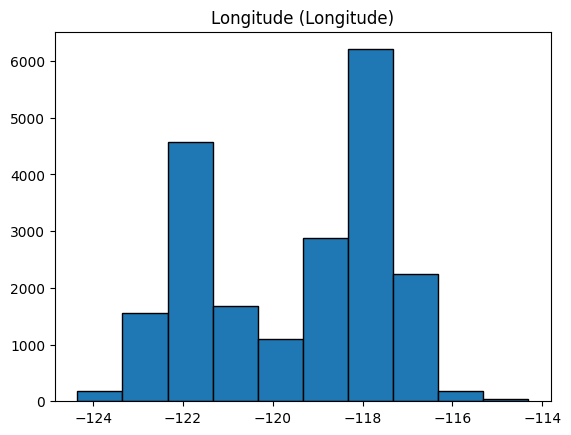

In [ ]:
[Histogram(housing[c]).plt(title_idx=c) for c in housing.columns]

In [ ]:
housing.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [ ]:
[feature.get_data_type(housing[c]) for c in housing.columns]

['Continuous',
 'Continuous',
 'Continuous',
 'Continuous',
 'Continuous',
 'Continuous',
 'Continuous',
 'Continuous']

In [ ]:
for i in housing.columns:
    for j in housing.columns:
        r = compare_distributions(housing[i], housing[j])
        # if (r[1] == True):
        print(i, j, r)

MedInc MedInc (np.float64(0.0), np.True_, np.float64(1.0))
MedInc HouseAge (np.float64(0.9269864341085271), np.False_, np.float64(0.0))
MedInc AveRooms (np.float64(0.4747577519379844), np.False_, np.float64(0.0))
MedInc AveBedrms (np.float64(0.9391957364341085), np.False_, np.float64(0.0))
MedInc Population (np.float64(0.9990794573643411), np.False_, np.float64(0.0))
MedInc AveOccup (np.float64(0.332170542635659), np.False_, np.float64(0.0))
MedInc Latitude (np.float64(1.0), np.False_, np.float64(0.0))
MedInc Longitude (np.float64(1.0), np.False_, np.float64(0.0))
HouseAge MedInc (np.float64(0.9269864341085271), np.False_, np.float64(0.0))
HouseAge HouseAge (np.float64(0.0), np.True_, np.float64(1.0))
HouseAge AveRooms (np.float64(0.9311531007751939), np.False_, np.float64(0.0))
HouseAge AveBedrms (np.float64(0.991812015503876), np.False_, np.float64(0.0))
HouseAge Population (np.float64(0.9943313953488372), np.False_, np.float64(0.0))
HouseAge AveOccup (np.float64(0.9679748062015504),

In [ ]:
from scipy.stats import ks_2samp

def compare_distributions(series1, series2, alpha=0.05):
    """
    Compare if two distributions are similar using the Kolmogorov-Smirnov test.
    
    Parameters:
        series1 (pd.Series): First distribution series.
        series2 (pd.Series): Second distribution series.
        alpha (float): Significance level for the test. Default is 0.05.
        
    Returns:
        bool: True if the distributions are similar (do not differ significantly), False otherwise.
        float: The p-value of the test.
    """
    # Perform the Kolmogorov-Smirnov test
    v, p_value = ks_2samp(series1, series2)
    
    # Compare p-value with the significance level
    similar = p_value > alpha
    return v,similar, p_value

In [ ]:
statistic, p_value = compare_distributions(df["Column1"], df["Column2"])
statistic, p_value

NameError: name 'df' is not defined

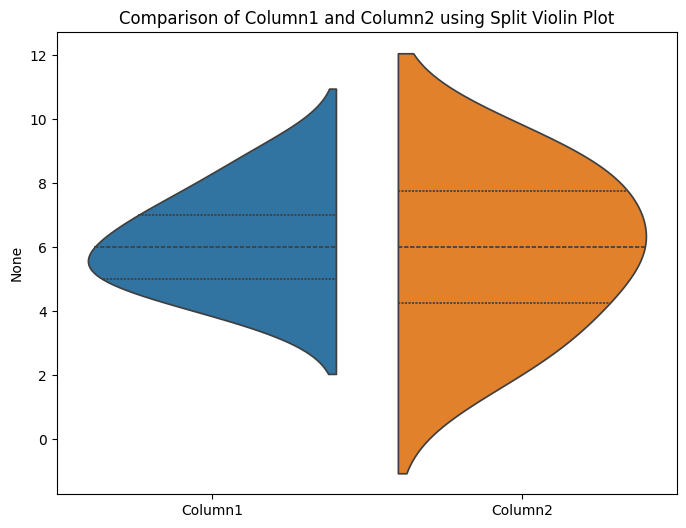

In [ ]:
# Sample DataFrame
df = pd.DataFrame({
    'Column1': [5, 7, 9, 4, 5, 6, 7, 8, 5, 6],
    'Column2': [3, 6, 9, 2, 4, 6, 7, 9, 5, 8]
})

# Prepare data for the plot
values = pd.concat([df['Column1'], df['Column2']])
columns = ['Column1'] * len(df) + ['Column2'] * len(df)

# Create the violin plot without a gap
plt.figure(figsize=(8, 6))
sns.violinplot(x=columns, y=values, hue=columns, split=True, inner="quartile", density_norm='count', dodge=False)
plt.title("Comparison of Column1 and Column2 using Split Violin Plot")
plt.show()

In [ ]:
import seaborn as sns 
from scipy.stats import ks_2samp

class Violin(Viz):

    def __init__(self, data: pd.DataFrame):
        self.x, self.y = data.T.values
        self.alpha = 0.05
        super().__init__(data)


    def compare_distributions(series1: pd.Series, series2: pd.Series, alpha=0.05):
        """
        Compare if two distributions are similar using the Kolmogorov-Smirnov test.
        
        Parameters:
            series1 (pd.Series): First distribution series.
            series2 (pd.Series): Second distribution series.
            alpha (float): Significance level for the test. Default is 0.05.
            
        Returns:
            bool: True if the distributions are similar (do not differ significantly), False otherwise.
            float: The p-value of the test.
        """
        # Perform the Kolmogorov-Smirnov test
        _, p_value = ks_2samp(series1, series2)
        
        # Compare p-value with the significance level
        similar = p_value > alpha
        return similar, p_value

    def _compute_feature(self):
        similarity = compare_distributions(self.x, self.y, self.alpha)
        return similarity

    def get_params(self):
        return {"feature": self.feature, "params": {"alpha":self.alpha}}

    def plt(self, **kwargs):
        if 'axs' in kwargs :
            kwargs["axs"].scatter(self.x, self.y)
            kwargs["axs"].set_title(f"{self.column_name[0]} x {self.column_name[1]}")
        else:
            ## Printar linha y com a distribuição
            plt.scatter(self.x, self.y)
            plt.title(f"{self.column_name[0]} x {self.column_name[1]}")
                

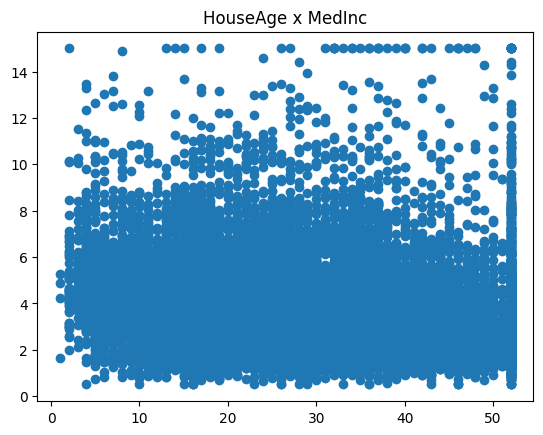

In [ ]:
Violin(housing[["HouseAge","MedInc"]]).plt()


# Tests

In [ ]:
obj = VizSelector.create(housing, 'hist')
top5 = obj.rank5()
# list(map(lambda x: x.get_params()["feature"], obj.rank5()))
obj.plt()

In [ ]:
obj = VizSelector.create(housing, 'scatter')
top5 = obj.rank5()
# list(map(lambda x: x.get_params()["feature"], obj.rank5()))
obj.plt()

In [ ]:
obj = VizSelector.create(housing, 'box')
top5 = obj.rank5()
# list(map(lambda x: x.get_params()["feature"], obj.rank5()))
obj.plt()

In [ ]:
list(map(lambda x: x.column_name, obj.rank5()))